In [1]:
%matplotlib inline

# Basic imports

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle


from scipy import stats
from Bio.Alphabet.IUPAC import IUPACProtein

import glob


import datetime
year = datetime.date.today().year
month = datetime.date.today().month

import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 12

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True


matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica Neue'
matplotlib.rcParams['font.weight']='ultralight'
matplotlib.rcParams['axes.axisbelow'] = True


# Functions for parsing couplings and contacts dataframes

In [4]:
from supporting_functions import *

# Single example

In [ ]:
contact_number_modifier = 1
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter']
df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

CA_distance_cutoff = 8
CB_distance_cutoffs = []
SC_distance_cutoffs = []

# couplings_file = '../../Structural_analysis/scratch/ancestral_seq/simulated_pyvolve_jtt_2.couplings'
# prot_name = '4kx4'
couplings_file = '../../Phylogenetic_couplings/Code/temp.couplings'
prot_name = '4kx4'
# couplings_file = '../../Structural_analysis/scratch/ancestral_seq/4kx4_noweight_gaps.couplings'
# prot_name = '4kx4'
# couplings_file = '../../Structural_analysis/scratch/ancestral_seq/raxml_temp.couplings'
# prot_name = '4kx4'
# couplings_file = '../../Structural_analysis/ecoli_all_pdbs/couplings/4kx4_193_rp75.couplings'
# prot_name = couplings_file.split('/')[-1].split('_')[0]
print('###', prot_name)
total_contacts = 0
cutoff=0
for metric in metrics:            
    df_couplings = pd.read_csv(couplings_file, sep=' ', header=None)
    contact_file_loc = '../../Structural_analysis/ecoli_all_pdbs/contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    try:
        df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    except FileNotFoundError:
        print(couplings_file)
        continue
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, 12)
    df_couplings, df_couplings_pivot, df_couplings_stack = process_couplings_df(df_couplings, df_contacts, 12)
    records = list(SeqIO.parse('../../Structural_analysis/ecoli_all_pdbs/wt_fastas/{}.fasta'.format(prot_name), 'fasta'))
    assert len(records)==1
    seq = str(records[0].seq)
    merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
    number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
    if metric == 'CA':
        total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=CA_distance_cutoff)
        print(metric, ppv, total_contacts)
    else:
        temp = df_contacts_stack.sort_values('distance')[:total_contacts]
        cutoff = temp.iloc[total_contacts-1]['distance']
        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
        print(metric, ppv, len(temp.index), cutoff)
        if metric == 'CB':
            CB_distance_cutoffs.append(cutoff)
        elif metric == 'SCcenter':
            SC_distance_cutoffs.append(cutoff)

    if metric == 'CA':
        lengths.append(len(df_contacts.columns))
    df_contacts_dict[metric][prot_name] = df_contacts_stack

# Iterating through all available
**This will take a few minutes to run**

In [7]:
hmmer_results_dict = {}
hmmer_results_dict['rp75'] =  pd.read_csv('../../Structural_analysis/rp75_phmmer.csv', index_col=0, header=None)
hmmer_results_dict['rp55'] =  pd.read_csv('../../Structural_analysis/rp55_phmmer.csv', index_col=0, header=None)
hmmer_results_dict['rp35'] =  pd.read_csv('../../Structural_analysis/rp35_phmmer.csv', index_col=0, header=None)
hmmer_results_dict['rp15'] =  pd.read_csv('../../Structural_analysis/rp15_phmmer.csv', index_col=0, header=None)


hmmer_results_dict['rp75'].head()

,1,2,3,4,5,6,7
0,,,,,,,
1,3f85,86,DONE,FMC1_ECOH1,CFA/I fimbrial subunit B,1.900000e-84,show
2,4hg0,26734,DONE,I6C1T0_SHIFL,Magnesium and cobalt efflux protein CorC,1.400000e-120,show
3,4lfu,5824,DONE,A0A1S9JLU1_SHIBO,Transcriptional regulator SdiA,1.000000e-157,show
4,1dd9,11801,DONE,I2RF52_ECOLX,DNA primase,6.500000e-203,show
5,2pth,12659,DONE,A0A017IF69_ECOLX,Peptidyl-tRNA hydrolase,1.300000e-127,show


In [ ]:
contact_number_modifier = 0.5
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter'] ###Order here is important, CA has to come first to get distance thresholds for others
df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

CA_distance_cutoff = 8
CB_distance_cutoffs = {}
SC_distance_cutoffs = {}

for couplings_file in glob.glob('../../Structural_analysis/ecoli_all_pdbs/couplings/rp75/*.couplings') +\
                        glob.glob('../../Structural_analysis/ecoli_all_pdbs/couplings/rp55/*.couplings') +\
                        glob.glob('../../Structural_analysis/ecoli_all_pdbs/couplings/rp35/*.couplings') +\
                        glob.glob('../../Structural_analysis/ecoli_all_pdbs/couplings/rp15/*.couplings'):
    prot_name = couplings_file.split('/')[-1].split('_')[0]
    db_name = couplings_file.split('/')[-1].split('_')[2].strip('.couplings')
    nseqs = hmmer_results_dict[db_name][hmmer_results_dict[db_name][1]==prot_name].iloc[0][2]
    if prot_name in df_contacts_dict[metrics[0]]:
        continue
    if nseqs < 2000:
        continue
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:            
        df_couplings = pd.read_csv(couplings_file, sep=' ', header=None)
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print(couplings_file)
            continue
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, 12)
        df_couplings, df_couplings_pivot, df_couplings_stack = process_couplings_df(df_couplings, df_contacts, 12)
        records = list(SeqIO.parse('../../Structural_analysis/ecoli_all_pdbs/wt_fastas/{}.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        number_to_test = round(len(df_contacts.index)* contact_number_modifier) 


        if metric == 'CA':
            total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
            ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=CA_distance_cutoff)
            print(metric, ppv, total_contacts)
            lengths.append(len(df_contacts.columns))
            sequences.append(nseqs)
        else:
            temp = df_contacts_stack.sort_values('distance')[:total_contacts]
            cutoff = temp.iloc[total_contacts-1]['distance']
            ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
            print(metric, ppv, len(temp.index), cutoff)
            if metric == 'CB':
                CB_distance_cutoffs[prot_name] = cutoff
            elif metric == 'SCcenter':
                SC_distance_cutoffs[prot_name] = cutoff
                
        ppv_dict[metric].append(ppv)
        df_contacts_dict[metric][prot_name] = df_contacts_stack

# Visualizing diffs

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
ax.violinplot([ppv_dict[metric] for metric in metrics], showextrema=False);
ax.boxplot([ppv_dict[metric] for metric in metrics]);
for i in range(len(lengths)):
    ax.plot([1,2,3], [ppv_dict['CA'][i], ppv_dict['CB'][i], ppv_dict['SCcenter'][i]], color='gray', alpha=0.2)
ax.set_xticklabels([r'C$\alpha$', r'C$\beta$', 'Side-chain\ncenter'])
ax.set_ylabel('PPV')
plt.savefig('{}/empirical_boxplots.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
loglog=True

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.75))
if not loglog:
    ax_arr[0].plot(ppv_dict['CA'], ppv_dict['SCcenter'], 'bo')
    ax_arr[0].plot([0.1,1], [0.1,1], 'k-')
else:
    ax_arr[0].loglog(ppv_dict['CA'], ppv_dict['SCcenter'], 'bo')
    ax_arr[0].loglog([0.1,1], [0.1,1], 'k-')
ax_arr[0].set_xlabel(r'PPV (C$\alpha$)')
ax_arr[0].set_ylabel('PPV (Side-chain center)')
deltas = np.array(ppv_dict['SCcenter']) / np.array(ppv_dict['CA'])
ax_arr[1].hist(deltas, 15, normed=True)
ax_arr[1].axvline(1, color='k')
ax_arr[1].set_xlabel(r'PPV ratio''\n'r'(Side chain center / C$\alpha$)')
print('#################')
print('CA vs SC center')
print(len(ppv_dict['CA']), np.median(np.array(ppv_dict['SCcenter'])/np.array(ppv_dict['CA'])))
print(stats.wilcoxon(ppv_dict['CA'], ppv_dict['SCcenter']))
plt.savefig('{}/sc_vs_ca_empirical.pdf'.format(figs_dir), bbox_inches='tight')

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(8,2.75))
if not loglog:
    ax_arr[0].plot(ppv_dict['CB'], ppv_dict['SCcenter'], 'bo')
    ax_arr[0].plot([0.05,0.8], [0.05,0.8], 'k-')
else:
    ax_arr[0].loglog(ppv_dict['CB'], ppv_dict['SCcenter'], 'bo')
    ax_arr[0].loglog([0.05,0.8], [0.05,0.8], 'k-')
ax_arr[0].set_xlabel(r'PPV (C$\beta$)')
ax_arr[0].set_ylabel('PPV (Side-chain center)')

deltas = np.array(ppv_dict['SCcenter']) / np.array(ppv_dict['CB'])
ax_arr[1].hist(deltas, 15, normed=True)
ax_arr[1].axvline(1, color='k')
ax_arr[1].set_xlabel(r'PPV ratio''\n'r'(Side chain center / C$\beta$)')
print('#################')
print('CB vs SC center')
print(len(ppv_dict['CB']), np.median(np.array(ppv_dict['SCcenter'])/np.array(ppv_dict['CB'])))
print(stats.wilcoxon(ppv_dict['CB'], ppv_dict['SCcenter']))

In [ ]:
metric = 'SCcenter'
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(sequences, ppv_dict[metric], 'bo')
ax.set_xlabel('Sequences in alignemnt')
ax.set_ylabel('PPV ({})'.format(metric))
print(stats.spearmanr(sequences, ppv_dict[metric]))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.75))

ax.hist(ppv_dict['CA'], 20, color='gray')
ax.set_xlabel(r'PPV (C$\alpha$)')
ax.set_ylabel('Counts')
plt.savefig('{}/ca_empirical_hist.pdf'.format(figs_dir), bbox_inches='tight')

# Contact density in structures

In [ ]:
chain_cutoff = 12
length_cutoff = 8.

lengths = []
possible_contacts = []
actual_contacts = []
all_contact_dists = []
for i, contact_file_loc in list(enumerate(glob.glob('../Data/Contact_matrices/*_SCcenter_contacts.csv')))[:]:
    df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
    lengths.append(len(df_contacts.index))
    all_contact_dists.extend(list(df_contacts_stack['distance']))
    actual_contacts.append((df_contacts_stack['distance'] <= length_cutoff).sum())
    possible_contacts.append(df_contacts_stack['distance'].count())
    if (df_contacts_stack['distance'] <= length_cutoff).sum() < len(df_contacts.index):
        print(contact_file_loc, len(df_contacts.index))

In [ ]:
fig, ax = plt.subplots()
ax.loglog(lengths, possible_contacts, 'bo')
ax.set_xlabel('Protein length')
ax.set_ylabel('Possible contacts')


fig, ax = plt.subplots()
ax.loglog(possible_contacts, actual_contacts, 'bo')
ax.set_xlabel('Possible contacts')
ax.set_ylabel('Actual contacts')

fig, ax = plt.subplots()
ax.plot(lengths, np.array(actual_contacts)/np.array(possible_contacts), 'bo')
ax.set_xlabel('Protein length')
ax.set_ylabel('Actual contacts/Possible contacts')

fig, ax = plt.subplots()
ax.plot(lengths, np.array(actual_contacts)/np.array(lengths), 'bo')
ax.set_xlabel('Protein length')
ax.set_ylabel('Actual contacts/Protein length')

In [ ]:
fig, ax = plt.subplots()
ax.axvspan(0, 7, color='k', alpha=0.15)
ax.hist(all_contact_dists, 1000);
ax.set_xlim(0, 20)
# ax.axvline(7, color='k')

# Contact identification differences by metric

# Amino acid representation in contacts

In [ ]:
contact_number_modifier = 1
chain_cutoff = 12
cutoff=''

# metric='CA'
metric='SCcenter'
aas = list(IUPACProtein.letters)

fp_distances = []
all_distances = []

successes_aa = {}
failures_aa = {}
for aa in aas:
    successes_aa[aa] = []
    failures_aa[aa] = []
    
prots_analyzed = []    
for couplings_file in glob.glob('../Data/Empirical_couplings/rp75/*.couplings') +\
                        glob.glob('../Data/Empirical_couplings/rp55/*.couplings') +\
                        glob.glob('../Data/Empirical_couplings/rp35/*.couplings'):

    prot_name = couplings_file.split('/')[-1].split('_')[0]
    print(prot_name)
    db_name = couplings_file.split('/')[-1].split('_')[2].strip('.couplings')
    nseqs = hmmer_results_dict[db_name][hmmer_results_dict[db_name][1]==prot_name].iloc[0][2]
    if prot_name in prots_analyzed:
        continue
    if nseqs < 2000:
        continue
        
    contact_file_loc = '../Data/Contact_matrices/{}_CA_contacts.csv'.format(prot_name, metric)
    try:
        df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    except FileNotFoundError:
        continue
        
    if metric == 'CA':
        cutoff = 8
    elif metric == 'SCcenter':
        cutoff = SC_distance_cutoffs[prot_name]
    elif metric == 'CB':
        cutoff = CB_distance_cutoffs[prot_name]
    
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    try:
        df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    except FileNotFoundError:
        continue

    df_couplings = pd.read_csv(couplings_file, sep=' ', header=None)    
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
    df_couplings, df_couplings_pivot, df_couplings_stack = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
    records = list(SeqIO.parse('../../Structural_analysis/ecoli_all_pdbs/wt_fastas/{}.fasta'.format(prot_name), 'fasta'))
    assert len(records)==1
    seq = str(records[0].seq)
    merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
    
    number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
    tps_df, fps_df, fns_df = errors_from_df(merged_df, number_to_test, cutoff)
    
    total_contacts += merged_df[merged_df['distance'] <= cutoff]['distance'].count()
    
    for aa in aas:
        tps_aa = tps_df[(tps_df['aa1_aa'] == aa) | (tps_df['aa2_aa'] == aa)]['distance'].count()
        tps_total = tps_df['distance'].count()
        
        temp_df = merged_df[(merged_df['aa1_aa'] == aa) | (merged_df['aa2_aa'] == aa)]
        contacts_aa = temp_df[temp_df['distance'] <= cutoff]['distance'].count()        
        contacts_total = merged_df[merged_df['distance'] <= cutoff]['distance'].count()
        
        if contacts_aa > 0:
            successes_aa[aa].append((tps_aa/tps_total)/(contacts_aa/contacts_total))
            
        fps_aa = fps_df[(fps_df['aa1_aa'] == aa) | (fps_df['aa2_aa'] == aa)]['distance'].count()
        fps_total = fps_df['distance'].count()
        
        temp_df = merged_df[(merged_df['aa1_aa'] == aa) | (merged_df['aa2_aa'] == aa)]
        contacts_aa = temp_df[temp_df['distance'] > cutoff]['distance'].count()        
        contacts_total = merged_df[merged_df['distance'] > cutoff]['distance'].count()
        
        if contacts_aa > 0:
            failures_aa[aa].append((fps_aa/fps_total)/(contacts_aa/contacts_total))
    fp_distances.extend(list(fps_df['distance']))
    all_distances.extend(list(merged_df['distance']))
    prots_analyzed.append(prot_name)

In [ ]:
success_labels = []
success = []
success_stdevs = []
success_stderrs = []

for aa,vals in successes_aa.items():
    success_labels.append(aa)
    success.append(np.mean(vals))
#     stdevs.append(np.std(vals))
#     stderrs.append(np.std(vals)/len(vals))

failures_labels = []
failures = []
failures_stdevs = []
failures_stderrs = []
for aa,vals in failures_aa.items():
    failures_labels.append(aa)
    failures.append(np.mean(vals))

In [ ]:
fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3), sharey=True)
ax = all_ax[0]
ax.axhline(1, c='k')
ax.bar(np.arange(len(success_labels)), success, 0.8)
# ax.bar(np.arange(len(rats)), rats, 0.8, yerr=stdevs)
ax.set_xticks(np.arange(len(success_labels)))
ax.set_xticklabels(success_labels);

ax = all_ax[1]
ax.axhline(1, c='k')
ax.axhline(1, c='k')
ax.bar(np.arange(len(failures_labels)), failures, 0.8)
# ax.bar(np.arange(len(rats)), rats, 0.8, yerr=stdevs)
ax.set_xticks(np.arange(len(failures_labels)))
ax.set_xticklabels(failures_labels);


In [ ]:
fig, ax = plt.subplots()
ax.hist(fp_distances)
print(len([i for i in fp_distances if i < 10]), len(fp_distances))

In [ ]:
fig, ax = plt.subplots()
ax.hist(all_distances)
print(len([i for i in all_distances if i < 10]), len(all_distances))


In [ ]:
fig, ax = plt.subplots()
ax.hist(all_distances, 20, normed=True, alpha=0.5)
ax.hist(fp_distances, 20, normed=True, alpha=0.5)

# Scratch

**comparing angles**

In [5]:
from collections import defaultdict

In [36]:
contact_number_modifier_list = [2, 1, 0.5]
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter']

angles_ppv_dict = {}
for angle in ['both', 'one', 'none']:
    angles_ppv_dict[angle] = []

CA_distance_cutoff = 8
results_dict = defaultdict(list)
done = []

for couplings_file in glob.glob('../Data/Empirical_couplings/rp75/*.couplings') +\
                        glob.glob('../Data/Empirical_couplings/rp55/*.couplings') +\
                        glob.glob('../Data/Empirical_couplings/rp35/*.couplings') +\
                        glob.glob('../Data/Empirical_couplings/rp15/*.couplings'):
    if len(done) > 40:
        continue
    prot_name = couplings_file.split('/')[-1].split('_')[0]
    db_name = couplings_file.split('/')[-1].split('_')[2].strip('.couplings')
    nseqs = hmmer_results_dict[db_name][hmmer_results_dict[db_name][1]==prot_name].iloc[0][2]
    if prot_name in done:
        continue
    if nseqs < 2000:
        continue
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:
        df_couplings = pd.read_csv(couplings_file, sep=' ', header=None)
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print("no contacts file found:", couplings_file)
            continue


        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
        df_couplings, df_couplings_pivot, df_couplings_stack = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
        records = list(SeqIO.parse('../../Structural_analysis/ecoli_all_pdbs/wt_fastas/{}.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        df_angles = pd.read_csv('../Data/Contact_matrices/{}_CA_angles.csv'.format(prot_name), index_col=0)
        df_angles.columns = df_angles.columns.astype(int)
        df_angles_stack = process_angles_df(df_angles, chain_cutoff)
        df_angles_stack['classification'] = 'none'
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) & ~(df_angles_stack['angles2'] < np.pi/2), 'one', inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) | ~(df_angles_stack['angles2'] < np.pi/2), 'both', inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'].isnull()), np.nan, inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles2'].isnull()), np.nan, inplace=True)

        merged_df = pd.concat([merged_df, df_angles_stack[['angles1', 'angles2', 'classification']]],\
                              axis=1, join_axes=[merged_df.index])
        
        for contact_number_modifier in contact_number_modifier_list:
            number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
            temp_df = merged_df[:number_to_test]

            temp = temp_df['classification'].value_counts()
            results_dict['Couplings_{}'.format(contact_number_modifier)].append(temp['both']/sum(temp))
#             results_dict['Couplings_{}'.format(contact_number_modifier)].append((temp['both']+temp['one'])/sum(temp))

        if metric == 'CA':
            temp = merged_df[merged_df['distance'] < CA_distance_cutoff]['classification'].value_counts()
            results_dict[metric].append(temp['both']/sum(temp))
#             results_dict[metric].append((temp['both']+temp['one'])/sum(temp))


            temp = merged_df['classification'].value_counts()
            results_dict['All'].append(temp['both']/sum(temp))
#             results_dict['All'].append((temp['both']+temp['one'])/sum(temp))
            total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()

        else:
            temp = merged_df.sort_values('distance')[:total_contacts]
            temp = temp['classification'].value_counts()
            results_dict[metric].append(temp['both']/sum(temp))
#             results_dict[metric].append((temp['both']+temp['one'])/sum(temp))
        done.append(prot_name)

### 3a7r (4807)
### 1jl1 (9383)
### 1dnl (7932)
### 3n37 (6815)
### 2ex2 (6594)
### 5ghu (3693)
### 4d02 (4572)
### 1k77 (5990)
### 1sur (7766)
### 1mug (2475)
### 3g7u (8620)
### 1qtw (5690)
### 1xw8 (6358)
### 1m33 (7799)


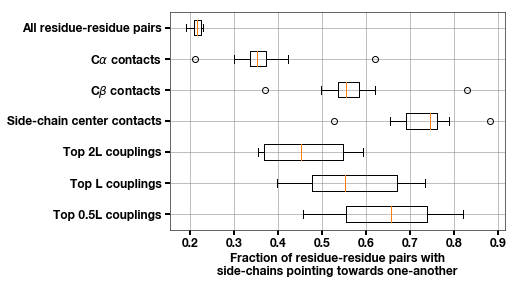

In [40]:
fig, ax = plt.subplots()
labels = ['Top 0.5L couplings', 'Top L couplings', 'Top 2L couplings', 'Side-chain center contacts',\
          r'C$\beta$ contacts', r'C$\alpha$ contacts', 'All residue-residue pairs']
ax.boxplot([results_dict['All'], results_dict['CA'], results_dict['CB'], results_dict['SCcenter'],\
           results_dict['Couplings_2'], results_dict['Couplings_1'], results_dict['Couplings_0.5']][::-1],\
           labels = labels, vert=False);
ax.set_xlabel('Fraction of residue-residue pairs with\nside-chains pointing towards one-another')